# PROBLEM DEFINITION
  
- In semiconductor manufacturing, the production of integrated circuits involves multiple complex processes, including wafer fabrication. Wafers are thin, round substrates made of semiconductor materials, and they undergo various manufacturing steps to create microchips. The quality of these wafers is critical for ensuring the reliability and performance of the final IC's.

- The manufacturing process of semiconducter wafers is susceptible to various defects and faults that can compromise the quality and yield of IC's. These faults can result from contamination, equipment malfunctions or process variations. Detecting and classifying these faults early in the manufacturing process is essential to minimze waste and ensure product quality.

## GOAL
- The goal of this experiment notebook is to findout a succesful / generalized predictive classifier model that can accurately classify semiconducter wafers as either "Good" or "Bad" based on sensor data collected during the manufacturing process. 
- According to the domain knowledge of expertizes and regarding business priorities and potential consequences of false predicted cases, the cost function is calculated to be 10.FN + 1.FP 


****

## DATA EXPLORATION

[x]head, info, description

[x]quick profiling reports

[x] missing values analysis

[x]duplicates

[x]outliers

[x]feature distributions

[x]imbalance check

[x]correlation analysis

[x]notes

### NOTES
- all meaningful input features are float64 dtype
- wafer id can be removed
- no duplicated rows
- raw data is highly unscaled
- lots of outliers, even when i set iqr_threshold to 5% and coefficient to 5, there were still lots of outliers
- as an alternative, i peformed multivariate outlier detection using LOF, the elbow method suggested the threshold score to be <-2
- there is no duplicated rows, but are a lot of (more than 100) duplicated columns, may be these are all zero columns.
- there are 112 columns of constant value "0" 
- best_fit_distribution types are found , re-assess after data transformation
- highly imbalanced dataset, handle imbalance with stratified kfold when splitting as train-test dataset
- correlation study is performed with filter condition of abs(corr)>95 or abs(cor)<100 and if the correlated column count > threshold=5  , some columns meeting these conditions are detected

In [154]:
import pandas as pd 
import numpy as np
import dtale
import seaborn as sns
import matplotlib.pyplot as plt 
from scipy import stats 
import scipy 


from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.neighbors import LocalOutlierFactor

from sklearn.preprocessing import StandardScaler , MinMaxScaler, RobustScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix,accuracy_score,f1_score, roc_auc_score, roc_curve, precision_score,recall_score

from xgboost import XGBClassifier
from catboost import CatBoostClassifier

from imblearn.combine import SMOTETomek # hybrid technique

from sklearn.base import BaseEstimator , TransformerMixin
from sklearn.pipeline import Pipeline

import pickle 


import os 
import warnings
warnings.filterwarnings("ignore")



In [3]:
%%html
<style>
.output_wrapper, .output {
    max-height: 800px; /* Adjust the width as needed */
}
</style>

In [4]:
valid_dataset_dir = "../valid_feature_store/valid_training_data/"


In [5]:
def restore_original_data()->pd.DataFrame:
    csv_file_list = os.listdir(valid_dataset_dir)
    df_merged = pd.DataFrame()
    for file in csv_file_list:
        file_path = os.path.join(valid_dataset_dir,file)
        df = pd.read_csv(file_path)
        df_merged = pd.concat(objs=[df_merged,df]) # merged around axis=0
        df_merged.drop(columns=["Wafer"],inplace=True)
        filt = df_merged["Good/Bad"]==1
        df_merged["Good/Bad"] = np.where(filt,1,0)

    return df_merged 

In [6]:
df_merged = restore_original_data()

In [461]:
df_merged.head()

,Sensor-1,Sensor-2,Sensor-3,Sensor-4,Sensor-5,Sensor-6,Sensor-7,Sensor-8,Sensor-9,Sensor-10,...,Sensor-582,Sensor-583,Sensor-584,Sensor-585,Sensor-586,Sensor-587,Sensor-588,Sensor-589,Sensor-590,Good/Bad
0,3076.81,2158.75,2208.2334,1517.0152,1.0980,100.0,110.1900,0.1247,1.4357,0.0089,...,64.2405,0.5016,0.0152,0.0040,3.0319,0.0465,0.0299,0.0090,64.2405,0
1,2951.62,2511.92,2253.5111,1397.5060,0.9660,100.0,109.7611,0.1210,1.5527,0.0119,...,0.0000,0.4953,0.0105,0.0037,2.1266,-0.0012,0.0252,0.0081,0.0000,0
2,2930.42,2505.17,2235.0556,1302.6607,1.6347,100.0,109.9856,0.1230,1.4588,-0.0143,...,NaN,0.4958,0.0111,0.0033,2.2296,-0.0012,0.0252,0.0081,0.0000,0
3,2997.28,2357.99,2141.0667,1236.5212,0.9698,100.0,98.3344,0.1238,1.5973,-0.0534,...,NaN,0.4962,0.0086,0.0024,1.7297,-0.0012,0.0252,0.0081,0.0000,0
4,3025.10,2475.18,2235.0556,1302.6607,1.6347,100.0,109.9856,0.1230,1.5525,-0.0078,...,NaN,0.4983,0.0159,0.0041,3.1927,-0.0012,0.0252,0.0081,0.0000,0


In [463]:
df_merged.describe().T 

,count,mean,std,min,25%,50%,75%,max
Sensor-1,1531.0,3015.024193,73.908774,2743.2400,2967.4650,3012.0900,3057.3900,3356.3500
Sensor-2,1530.0,2495.483771,80.495576,2158.7500,2452.1825,2498.8400,2538.5000,2846.4400
Sensor-3,1523.0,2200.370187,29.461460,2060.6600,2180.9666,2200.9889,2217.8667,2315.2667
Sensor-4,1523.0,1400.184797,443.937101,0.0000,1084.3779,1287.3538,1593.1220,3715.0417
Sensor-5,1523.0,4.255665,56.906664,0.6815,1.0177,1.3168,1.5291,1114.5366
...,...,...,...,...,...,...,...,...
Sensor-587,1537.0,0.021432,0.012398,-0.0169,0.0134,0.0207,0.0276,0.1028
Sensor-588,1537.0,0.016414,0.008768,0.0032,0.0106,0.0148,0.0203,0.0799
Sensor-589,1537.0,0.005268,0.002865,0.0010,0.0033,0.0046,0.0064,0.0286
Sensor-590,1537.0,99.777881,94.560344,0.0000,44.2355,71.5753,115.1005,737.3048


In [464]:
d= dtale.show(df_merged)

In [19]:
d.open_browser()

### EDA: Missing Value Analyis

In [7]:
def missing_values_table(dataframe:pd.DataFrame,is_return= False):
    na_cols = [col for col in dataframe.columns if dataframe[col].isna().sum()>0]
    na_data = dataframe[na_cols].isna().sum().sort_values(ascending=False)
    ratio = (dataframe[na_cols].isna().sum()/dataframe.shape[0]*100).sort_values(ascending=False)
    missing_df = pd.concat(objs=[na_data,np.round(ratio,2)],axis=1,keys= ["#missing","ratio"])
    print(missing_df,end="\n")
    if is_return:
        return (na_cols,missing_df)
    return missing_df

In [466]:
missing_table = missing_values_table(df_merged)

            #missing  ratio
Sensor-159      1399  91.02
Sensor-158      1399  91.02
Sensor-294      1399  91.02
Sensor-293      1399  91.02
Sensor-493      1311  85.30
...              ...    ...
Sensor-458         1   0.07
Sensor-457         1   0.07
Sensor-456         1   0.07
Sensor-455         1   0.07
Sensor-586         1   0.07

[534 rows x 2 columns]


In [22]:
filtered_missed_table = missing_table.query("ratio>60")

In [23]:
filtered_missed_table

,#missing,ratio
Sensor-159,1399,91.02
Sensor-158,1399,91.02
Sensor-294,1399,91.02
Sensor-293,1399,91.02
Sensor-493,1311,85.30
Sensor-86,1311,85.30
Sensor-359,1311,85.30
Sensor-221,1311,85.30
Sensor-384,988,64.28
Sensor-519,988,64.28


##### ->missing value analysis w/ target variable

In [8]:
def missing_vs_target(dataframe:pd.DataFrame,target:str,na_cols:list):
    i=0
    temp_df = dataframe.copy()
    for col in na_cols:
        temp_df[col + "_NA_FLAG"] = np.where(temp_df[col].isna(),1,0)
    
    na_flags= [col for col in temp_df.columns if "_NA_FLAG" in col ]
    

    
    for col in na_flags:
        table= pd.DataFrame({
            "Target_Mean": temp_df.groupby(col)[target].mean(),
            "count":temp_df.groupby(col)[target].count()
        })

        if (abs(table.iloc[1,0])> 0.30) and  (abs(table.iloc[1,0])< 0.70) :
            i+=1
            print(table,end="\n\n")

        
    print(i)

In [25]:
na_cols = missing_values_table(df_merged,is_return=True)[0]

            #missing  ratio
Sensor-159      1399  91.02
Sensor-158      1399  91.02
Sensor-294      1399  91.02
Sensor-293      1399  91.02
Sensor-493      1311  85.30
...              ...    ...
Sensor-458         1   0.07
Sensor-457         1   0.07
Sensor-456         1   0.07
Sensor-455         1   0.07
Sensor-586         1   0.07

[534 rows x 2 columns]


In [26]:
missing_vs_target(df_merged,"Good/Bad",na_cols)

                   Target_Mean  count
Sensor-54_NA_FLAG                    
0                    -0.885192   1533
1                    -0.500000      4

                   Target_Mean  count
Sensor-55_NA_FLAG                    
0                    -0.885192   1533
1                    -0.500000      4

                   Target_Mean  count
Sensor-56_NA_FLAG                    
0                    -0.885192   1533
1                    -0.500000      4

                   Target_Mean  count
Sensor-57_NA_FLAG                    
0                    -0.885192   1533
1                    -0.500000      4

                   Target_Mean  count
Sensor-58_NA_FLAG                    
0                    -0.885192   1533
1                    -0.500000      4

                   Target_Mean  count
Sensor-59_NA_FLAG                    
0                    -0.885192   1533
1                    -0.500000      4

                    Target_Mean  count
Sensor-191_NA_FLAG                    
0   

In [9]:
def missing_row_analysis(dataframe:pd.DataFrame):
    table= pd.DataFrame({
        "#missing":dataframe.isna().sum(axis=1).sort_values(ascending=False),
        "ratio": dataframe.isna().sum(axis=1).sort_values(ascending=False)/ dataframe.shape[0]*100
    })
    return table 

    

In [28]:
missing_row_analysis(df_merged)

,#missing,ratio
36,152,9.889395
34,148,9.629148
31,140,9.108653
22,100,6.506181
81,100,6.506181
...,...,...
22,4,0.260247
26,4,0.260247
43,4,0.260247
87,4,0.260247


### EDA: Outlier Detection

In [29]:
import matplotlib.pyplot as plt 

In [9]:
df_merged.columns 

Index(['Sensor-1', 'Sensor-2', 'Sensor-3', 'Sensor-4', 'Sensor-5', 'Sensor-6',
       'Sensor-7', 'Sensor-8', 'Sensor-9', 'Sensor-10',
       ...
       'Sensor-582', 'Sensor-583', 'Sensor-584', 'Sensor-585', 'Sensor-586',
       'Sensor-587', 'Sensor-588', 'Sensor-589', 'Sensor-590', 'Good/Bad'],
      dtype='object', length=591)

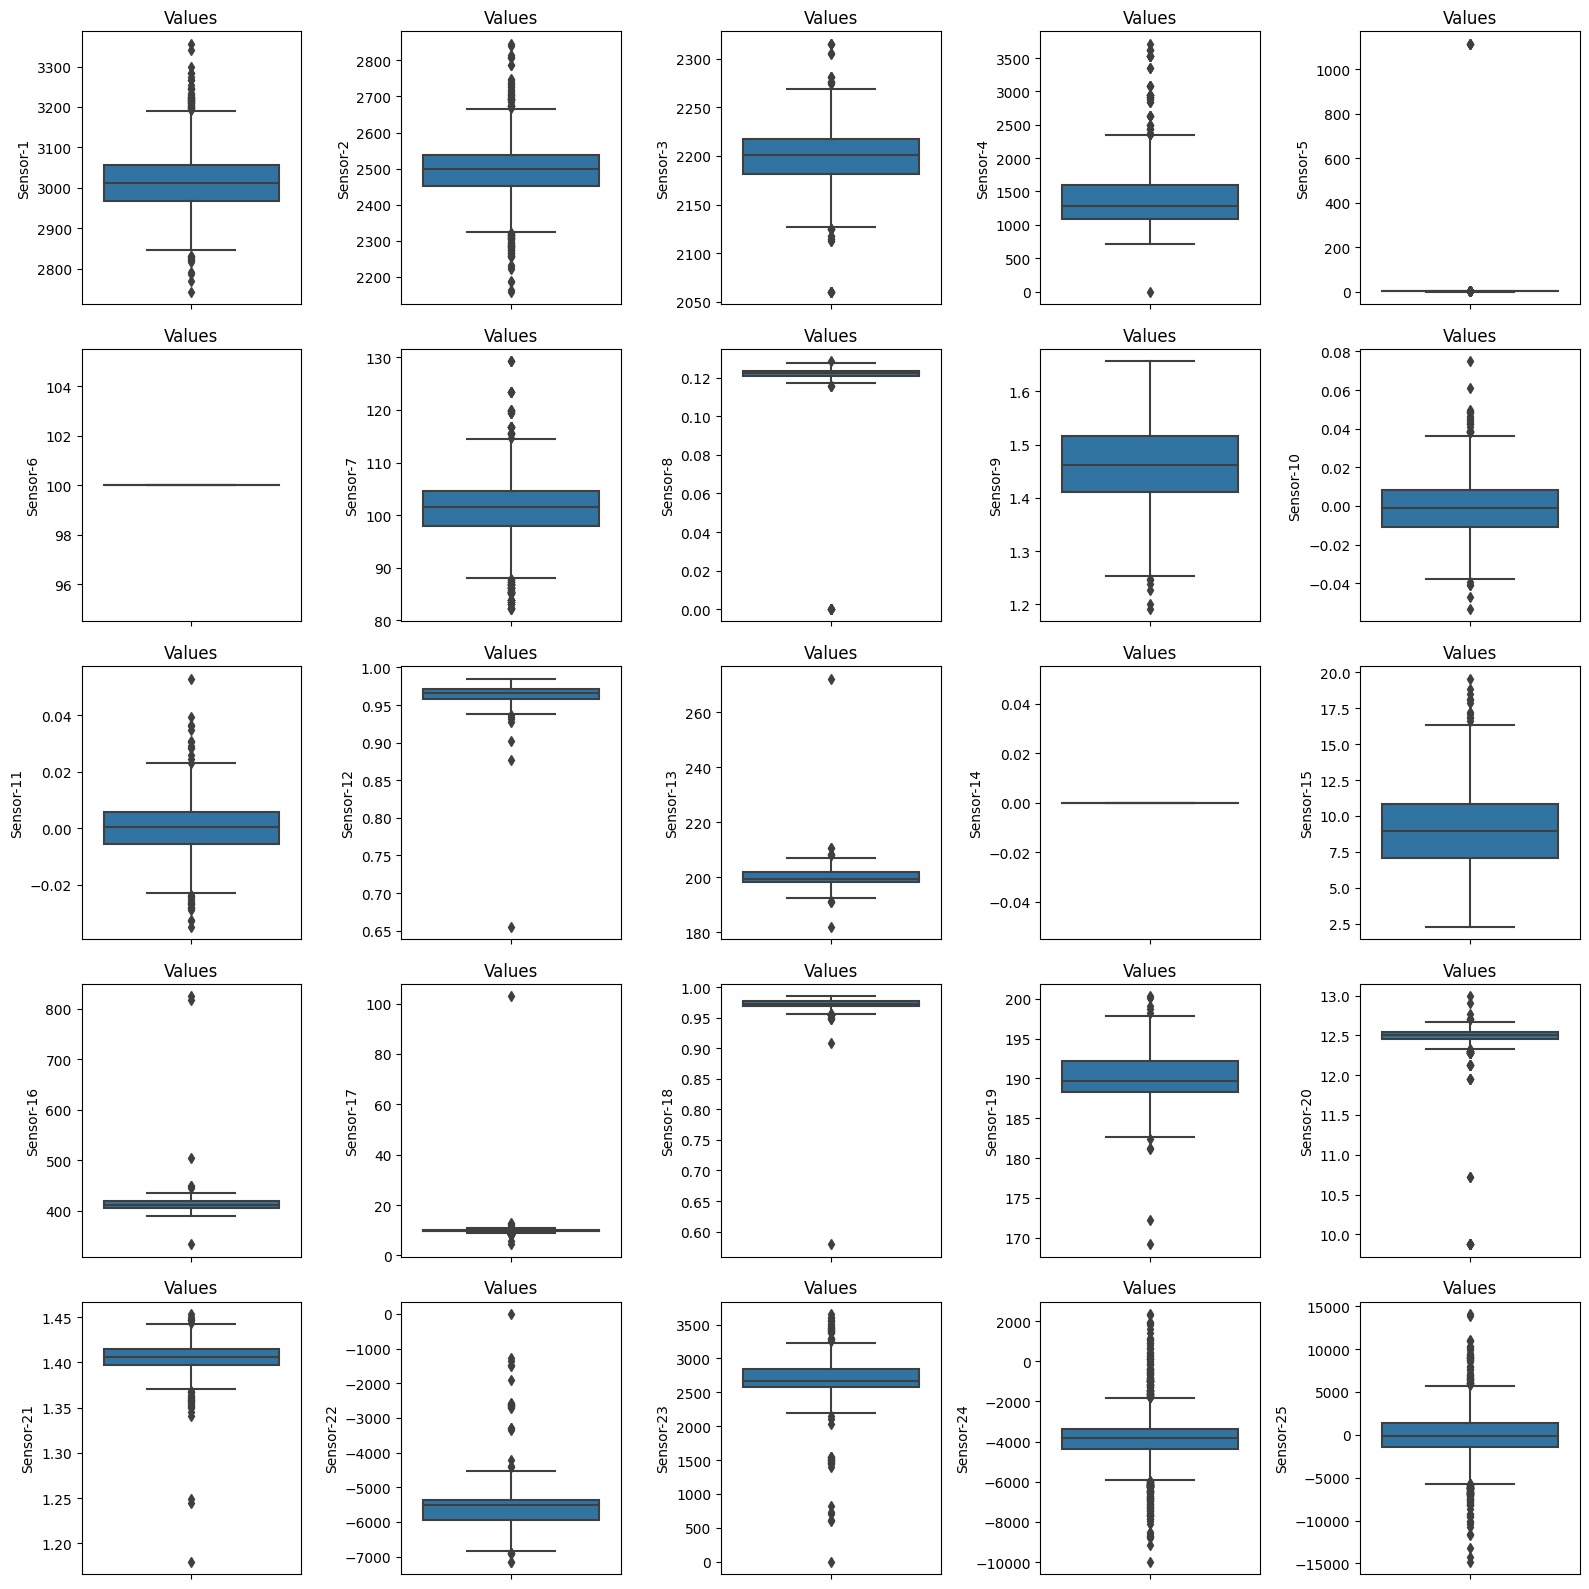

In [10]:
fig, axs = plt.subplots(nrows=5, ncols=5, figsize=(16, 16))
#print(axs)

for i, col in enumerate(df_merged.columns[:25]):
    row = i // 5  
    col_num = i % 5  
    #print(row,col_num)
    sns.boxplot(y=df_merged[col], ax=axs[row, col_num])
    axs[row, col_num].set_title("Values")
    axs[row, col_num].set_ylabel(col)

plt.tight_layout() 
plt.show()


In [11]:
def iqr_threshold(dataframe:pd.DataFrame,col_name:str,threshold,coeff):
    q1= dataframe[col_name].quantile(threshold)
    q3 = dataframe[col_name].quantile(1-threshold)
    iqr = q3-q1 
    upper = q3 + coeff*iqr 
    lower = q1 - coeff*iqr
    return lower,upper 


In [12]:
def detect_outliers(dataframe:pd.DataFrame,col_name,index=True,threshold:float=0.05,coeff=1.5):
    lower,upper = iqr_threshold(dataframe,col_name,threshold,coeff)
    filt = (dataframe[col_name] > upper) | (dataframe[col_name] < lower)
    if index:
        return (dataframe[filt].index, dataframe.loc[dataframe[filt].index,col_name])
    else: 
        return dataframe[filt]
        

In [34]:
for col in df_merged.columns:
    
    indices, outliers = detect_outliers(df_merged,col,coeff=5)
    if len(indices)>3:
        print(col,"mean:",df_merged[col].mean())
        print(indices)
        print(outliers)

        

Sensor-5 mean: 4.255664543663823
Index([74, 90, 16, 26], dtype='int64')
74       1.3954
74    1112.1600
74       2.1216
74       1.5611
74       1.2150
        ...    
26       0.8117
26       1.0204
26       1.1853
26       1.2484
26       0.8579
Name: Sensor-5, Length: 62, dtype: float64
Sensor-8 mean: 0.12181681937172775
Index([16, 18, 26, 29, 30, 31, 37, 39], dtype='int64')
16    0.1233
16    0.1237
16    0.1234
16    0.1216
16    0.1249
       ...  
39    0.1235
39    0.1232
39    0.1206
39    0.1214
39    0.1224
Name: Sensor-8, Length: 126, dtype: float64
Sensor-20 mean: 12.481922054973824
Index([77, 84, 89, 91, 29, 31, 4, 1, 44, 78], dtype='int64')
77    12.4922
77     9.8773
77    12.5951
77    12.4661
77    12.5782
       ...   
78    12.5949
78    12.4049
78     9.8773
78    12.4600
78    12.4661
Name: Sensor-20, Length: 154, dtype: float64
Sensor-27 mean: 1.9433158306188927
Index([37,  0,  8, 73, 90, 93,  4,  5, 13, 16, 23, 25, 33, 42, 61, 66, 69, 70,
       57, 13, 14, 53, 

#### EDA- OUTLIER DETECTION : LOCAL OUTLIER FACTOR 

In [10]:
from sklearn.neighbors import LocalOutlierFactor

In [37]:
clf = LocalOutlierFactor(n_neighbors=100, contamination=0.1)
X = df_merged.fillna(0)
norm_X = (X-X.mean())/X.std()
y_pred = clf.fit_predict(X)
scores = sorted(clf.negative_outlier_factor_)
scores_2= clf.negative_outlier_factor_

In [13]:
scores

[-6.152074722419638,
 -4.825237655897288,
 -4.584562603558441,
 -4.201624571144099,
 -4.177001722884122,
 -4.123022855695427,
 -3.5499205985649747,
 -3.222296180806306,
 -3.2182630094807676,
 -3.199430321262291,
 -3.1702094929198283,
 -3.091207630774953,
 -2.4829113351168157,
 -2.165957052068143,
 -2.0076488474063305,
 -1.8958650621964062,
 -1.8839499325703108,
 -1.8760244301535458,
 -1.8524603191056304,
 -1.847671349030876,
 -1.8446901020757547,
 -1.8086096926271602,
 -1.808434257198234,
 -1.805881240837698,
 -1.7940052632152192,
 -1.793155441267917,
 -1.7876633483886724,
 -1.7768770651192134,
 -1.7492311868013968,
 -1.7470945209720814,
 -1.7435830246130322,
 -1.741922843553923,
 -1.7349372745819245,
 -1.7346475869966276,
 -1.7325898039772922,
 -1.717917696217529,
 -1.7134392080868701,
 -1.7087439931033312,
 -1.7002794287890601,
 -1.6935870329876637,
 -1.6904668868800214,
 -1.690386826733247,
 -1.681980155094535,
 -1.6814757271857839,
 -1.6529602579580263,
 -1.6440410077113163,
 -1.64

In [38]:
scores_2 

array([-1.15271498, -0.98863809, -1.04538674, ..., -1.05112648,
       -1.0301617 , -1.09446104])

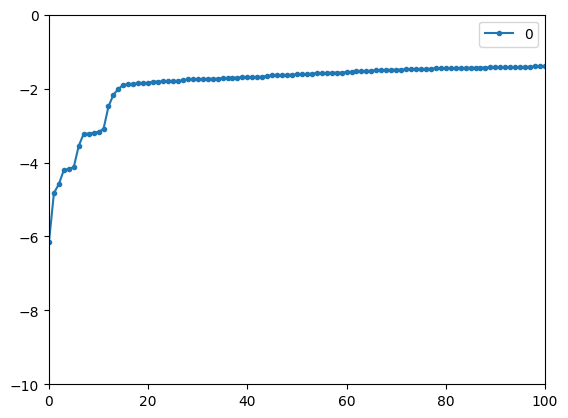

In [14]:
scores = pd.DataFrame(scores)
scores.plot( xlim = [0,100],ylim = [-10,0],style='.-')
plt.show()

In [15]:
scores

,0
0,-6.152075
1,-4.825238
2,-4.584563
3,-4.201625
4,-4.177002
...,...
1532,-0.972607
1533,-0.969055
1534,-0.968953
1535,-0.963351


In [16]:
scores[scores[0]<-2] # then we need to access the indices of these data points

,0
0,-6.152075
1,-4.825238
2,-4.584563
3,-4.201625
4,-4.177002
5,-4.123023
6,-3.549921
7,-3.222296
8,-3.218263
9,-3.199430


In [39]:
scores_2 = pd.DataFrame(scores_2)
scores_2

,0
0,-1.152715
1,-0.988638
2,-1.045387
3,-1.046199
4,-1.342985
...,...
1532,-1.056860
1533,-0.981718
1534,-1.051126
1535,-1.030162


In [40]:

outliers = scores_2[scores_2[0]<-2] # then we need to access the indices of these data points

In [41]:
outlier_indices = outliers.index

In [42]:
outlier_indices

Index([  44,  174,  190,  299,  345,  400,  404,  417,  421,  422,  424,  425,
        426,  430,  435,  451,  541,  573,  574,  623,  639,  664,  673,  737,
        786,  803,  839,  850,  853,  863,  865,  870,  886,  902,  906,  909,
        911,  914,  917,  920,  922,  929,  934,  941,  942,  950,  953,  959,
        960,  961,  962,  965,  970,  979,  991,  998, 1000, 1003, 1006, 1060,
       1081, 1108, 1129, 1159, 1178, 1187, 1269, 1297, 1298, 1308, 1327, 1350,
       1351, 1379, 1390, 1393, 1402, 1403, 1409, 1443],
      dtype='int64')

In [43]:
for index in outlier_indices:
    
    print(df_merged.iloc[index]["Good/Bad"])

-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
1.0
-1.0
-1.0
-1.0
1.0


#### EDA: Duplicate Detection

In [41]:
# DUPLICATED COLUMNS
duplicated_df = df_merged.T[df_merged.T.duplicated()]
duplicated_df

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
Sensor-150,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Sensor-180,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Sensor-187,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Sensor-190,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Sensor-192,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sensor-535,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Sensor-536,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Sensor-537,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Sensor-538,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [42]:
duplicated_df.index

Index(['Sensor-150', 'Sensor-180', 'Sensor-187', 'Sensor-190', 'Sensor-192',
       'Sensor-193', 'Sensor-194', 'Sensor-195', 'Sensor-227', 'Sensor-230',
       ...
       'Sensor-530', 'Sensor-531', 'Sensor-532', 'Sensor-533', 'Sensor-534',
       'Sensor-535', 'Sensor-536', 'Sensor-537', 'Sensor-538', 'Sensor-539'],
      dtype='object', length=104)

In [43]:
df_merged.T[df_merged.T.duplicated()].shape

(104, 1537)

In [467]:
# DUPLICATED ROWS:
df_merged.duplicated().sum()

0

In [45]:
filt = df_merged[col]==0

In [46]:
zero_check = [col  for col in df_merged.columns if (df_merged[col].fillna(0)==0.0).sum()==df_merged.shape[0]]

In [47]:
zero_check

['Sensor-14',
 'Sensor-53',
 'Sensor-98',
 'Sensor-142',
 'Sensor-150',
 'Sensor-179',
 'Sensor-180',
 'Sensor-187',
 'Sensor-190',
 'Sensor-191',
 'Sensor-192',
 'Sensor-193',
 'Sensor-194',
 'Sensor-195',
 'Sensor-227',
 'Sensor-230',
 'Sensor-231',
 'Sensor-232',
 'Sensor-233',
 'Sensor-234',
 'Sensor-235',
 'Sensor-236',
 'Sensor-237',
 'Sensor-238',
 'Sensor-241',
 'Sensor-242',
 'Sensor-243',
 'Sensor-244',
 'Sensor-257',
 'Sensor-258',
 'Sensor-259',
 'Sensor-260',
 'Sensor-261',
 'Sensor-262',
 'Sensor-263',
 'Sensor-264',
 'Sensor-265',
 'Sensor-266',
 'Sensor-267',
 'Sensor-277',
 'Sensor-285',
 'Sensor-314',
 'Sensor-315',
 'Sensor-316',
 'Sensor-323',
 'Sensor-326',
 'Sensor-327',
 'Sensor-328',
 'Sensor-329',
 'Sensor-330',
 'Sensor-331',
 'Sensor-365',
 'Sensor-370',
 'Sensor-371',
 'Sensor-372',
 'Sensor-373',
 'Sensor-374',
 'Sensor-375',
 'Sensor-376',
 'Sensor-379',
 'Sensor-380',
 'Sensor-381',
 'Sensor-382',
 'Sensor-395',
 'Sensor-396',
 'Sensor-397',
 'Sensor-398'

In [48]:
len(zero_check)

112

### EDA: Distribution Analysis

In [13]:
from scipy import stats

In [15]:
dist_types = [stats.norm, stats.expon, stats.gamma, stats.lognorm, stats.pareto]

In [14]:
def get_distribution(dataframe:pd.DataFrame, col_name):
    best_fit = None 
    best_p_value = np.inf 

    for dist in dist_types:
        params = dist.fit(dataframe[col_name].fillna(0.00001))
        _, p_value = stats.kstest(dataframe[col_name].fillna(0.00001), dist.cdf, args=params)
        if p_value < best_p_value:
            best_fit = dist 
            best_p_value = p_value

    print(f"{col_name} -> Best-fit distribution: {best_fit.name}")
    return best_fit.name 

In [54]:
best_fit_list = []
for col in df_merged.columns[:-1]:
    best_fit = get_distribution(df_merged,col)
    best_fit_list.append(best_fit)

Sensor-1 -> Best-fit distribution: expon
Sensor-2 -> Best-fit distribution: expon
Sensor-3 -> Best-fit distribution: expon
Sensor-4 -> Best-fit distribution: lognorm
Sensor-5 -> Best-fit distribution: norm
Sensor-6 -> Best-fit distribution: norm
Sensor-7 -> Best-fit distribution: expon
Sensor-8 -> Best-fit distribution: expon
Sensor-9 -> Best-fit distribution: expon
Sensor-10 -> Best-fit distribution: pareto
Sensor-11 -> Best-fit distribution: pareto
Sensor-12 -> Best-fit distribution: expon
Sensor-13 -> Best-fit distribution: expon
Sensor-14 -> Best-fit distribution: norm
Sensor-15 -> Best-fit distribution: pareto
Sensor-16 -> Best-fit distribution: expon
Sensor-17 -> Best-fit distribution: expon
Sensor-18 -> Best-fit distribution: expon
Sensor-19 -> Best-fit distribution: expon
Sensor-20 -> Best-fit distribution: expon
Sensor-21 -> Best-fit distribution: expon
Sensor-22 -> Best-fit distribution: gamma
Sensor-23 -> Best-fit distribution: expon
Sensor-24 -> Best-fit distribution: logno

In [55]:
best_fits = pd.Series(best_fit_list)

In [56]:
best_fits.value_counts()

norm       153
gamma      148
expon      134
pareto     112
lognorm     43
Name: count, dtype: int64

### EDA: Target Imbalance Check

In [57]:
df_merged["Good/Bad"].value_counts(normalize=True)

Good/Bad
-1    0.942095
 1    0.057905
Name: proportion, dtype: float64

### EDA: Correlation Analysis

In [58]:
corr_matrix =  df_merged.corr(method="pearson")

In [59]:
filt = (abs(corr_matrix)>0.95) & (abs(corr_matrix)<1.00)

In [60]:
threshold = 5
corr_counts = filt.sum(axis=1)

In [61]:
corr_counts[corr_counts>2].sort_values(ascending=False)

Sensor-245    9
Sensor-383    9
Sensor-519    9
Sensor-422    9
Sensor-517    9
Sensor-246    8
Sensor-247    8
Sensor-385    8
Sensor-384    8
Sensor-518    8
Sensor-284    7
Sensor-149    7
Sensor-153    6
Sensor-288    6
Sensor-173    5
Sensor-426    5
Sensor-348    5
Sensor-310    5
Sensor-308    5
Sensor-428    5
Sensor-175    5
Sensor-444    5
Sensor-446    5
Sensor-17     5
Sensor-207    4
Sensor-110    4
Sensor-391    3
Sensor-300    3
Sensor-343    3
Sensor-301    3
Sensor-75     3
Sensor-290    3
Sensor-253    3
Sensor-166    3
Sensor-165    3
Sensor-155    3
Sensor-118    3
Sensor-525    3
dtype: int64

In [62]:
df_merged.columns[corr_counts>threshold]

Index(['Sensor-149', 'Sensor-153', 'Sensor-245', 'Sensor-246', 'Sensor-247',
       'Sensor-284', 'Sensor-288', 'Sensor-383', 'Sensor-384', 'Sensor-385',
       'Sensor-422', 'Sensor-517', 'Sensor-518', 'Sensor-519'],
      dtype='object')

****

****

## DATA TRANSFORMATION & FEATURE ENGINEERING

### NOTES (COPY)
- all meaningful input features are float64 dtype
- wafer id can be removed
- raw data is highly unscaled
- lots of outliers, even when i set iqr_threshold to 5% and coefficient to 5, there were still lots of outliers
- as an alternative, i peformed multivariate outlier detection using LOF, the elbow method suggested the threshold score to be <-2
- there is no duplicated rows, but are a lot of (more than 100) duplicated columns, may be these are all zero columns.
- there are 112 columns of constant value "0" 
- best_fit_distribution types are found , re-assess after data transformation
- highly imbalanced dataset, handle imbalance with stratified kfold when splitting as train-test dataset
- correlation study is performed with filter condition of abs(corr)>95 or abs(cor)<100 and if the correlated column count > threshold=5  , some columns meeting these conditions are detected

# DATA TRANFORMATION TASK LIST
##### (!) turn all the work into modular functions / classes

[x] - handle unwanted data

[x] - drop zero std columns

[x] - drop highly correlated columns

[x] - drop duplicated columns/rows

[x]  - handle missing values

[x] - handle outliers

[] - scale the dataframe

     - provide different scaling options
     
     - check distributions afterwards



In [11]:
df_merged.columns

Index(['Sensor-1', 'Sensor-2', 'Sensor-3', 'Sensor-4', 'Sensor-5', 'Sensor-6',
       'Sensor-7', 'Sensor-8', 'Sensor-9', 'Sensor-10',
       ...
       'Sensor-582', 'Sensor-583', 'Sensor-584', 'Sensor-585', 'Sensor-586',
       'Sensor-587', 'Sensor-588', 'Sensor-589', 'Sensor-590', 'Good/Bad'],
      dtype='object', length=591)

In [12]:
df_merged.shape 

(1537, 591)

#### -> DATA TRANSFORMATION: ZERO STD CHECK

In [502]:
zero_check = [col  for col in df_merged.columns if (df_merged[col].fillna(0)==0.0).sum()==df_merged.shape[0]]

In [503]:
len(zero_check)

112

In [67]:
(df_merged.std() == 0 ).sum() # 112 of them are all zero columns

116

In [16]:
def drop_zero_std(dataframe:pd.DataFrame)->pd.DataFrame:
    zero_std_cols = dataframe.columns[dataframe.std()==0]
    dataframe2 = dataframe.drop(columns=zero_std_cols)
    return dataframe2

In [481]:
df_zero_std_dropped = drop_zero_std(df_merged)

****

#### -> DATA TRANSFORMATION: Drop highly correlated columns

In [471]:
corr_matrix = df_merged.corr(method="pearson")
filt = (abs(corr_matrix)>0.95) & (abs(corr_matrix)<1.00) # threshold 95% 
threshold = 5
corr_counts = filt.sum(axis=1)
corr_counts[corr_counts>2].sort_values(ascending=False)

Sensor-245    9
Sensor-383    9
Sensor-519    9
Sensor-422    9
Sensor-517    9
Sensor-246    8
Sensor-247    8
Sensor-385    8
Sensor-384    8
Sensor-518    8
Sensor-284    7
Sensor-149    7
Sensor-153    6
Sensor-288    6
Sensor-173    5
Sensor-426    5
Sensor-348    5
Sensor-310    5
Sensor-308    5
Sensor-428    5
Sensor-175    5
Sensor-444    5
Sensor-446    5
Sensor-17     5
Sensor-207    4
Sensor-110    4
Sensor-391    3
Sensor-300    3
Sensor-343    3
Sensor-301    3
Sensor-75     3
Sensor-290    3
Sensor-253    3
Sensor-166    3
Sensor-165    3
Sensor-155    3
Sensor-118    3
Sensor-525    3
dtype: int64

In [17]:
def drop_highly_correlated_columns(dataframe:pd.DataFrame,corr_threshold=0.95,count_threshold=3):

    corr_matrix= dataframe.corr(method="pearson")
    filt = (abs(corr_matrix)>corr_threshold) & (abs(corr_matrix)<1.00)
    corr_counts = filt.sum(axis=1)
    #highly_correlated = corr_counts[cor_counts > count_threshold].sort_values(ascending=False)
    highly_correlated_cols = dataframe.columns[corr_counts>count_threshold]

    return dataframe.drop(columns=highly_correlated_cols)

In [473]:
df_no_corr = drop_highly_correlated_columns(dataframe=df_merged,count_threshold=5)

In [474]:
df_no_corr.shape 

(1537, 577)

****

#### -> DATA TRANSFORMATION: Drop duplicated columns

In [475]:
df_merged.T[df_merged.T.duplicated()].index

Index(['Sensor-150', 'Sensor-180', 'Sensor-187', 'Sensor-190', 'Sensor-192',
       'Sensor-193', 'Sensor-194', 'Sensor-195', 'Sensor-227', 'Sensor-230',
       ...
       'Sensor-530', 'Sensor-531', 'Sensor-532', 'Sensor-533', 'Sensor-534',
       'Sensor-535', 'Sensor-536', 'Sensor-537', 'Sensor-538', 'Sensor-539'],
      dtype='object', length=104)

In [18]:
def drop_duplicated_cols(dataframe:pd.DataFrame)->pd.DataFrame:
    duplicated_cols = dataframe.T[dataframe.T.duplicated()].index
    return dataframe.drop(columns=duplicated_cols)

****

#### -> DATA TRANSFORMATION: Handle Missing Values

In [19]:
class HandleMissingValues:
    def __init__(self,dataframe:pd.DataFrame):
        self.dataframe = dataframe


    def missing_values_table(self,is_return= True):

        """
        Generate a summary of missing values in the DataFrame.

        Parameters:
        - is_return (bool)

        Returns:
        - If is_return is True, returns a tuple containing a list of columns with missing values and a DataFrame summarizing the missing values.
        - If is_return is False, returns a DataFrame summarizing the missing values.
        """

        na_cols = [col for col in self.dataframe.columns if self.dataframe[col].isna().sum()>0]
        na_data = self.dataframe[na_cols].isna().sum().sort_values(ascending=False)
        ratio = (self.dataframe[na_cols].isna().sum()/self.dataframe.shape[0]*100).sort_values(ascending=False)
        missing_df = pd.concat(objs=[na_data,np.round(ratio,2)],axis=1,keys= ["#missing","ratio"])
        print(missing_df,end="\n")
        if is_return:
            return (na_cols,missing_df)
        else:
            return missing_df


    def missing_vs_target(self,target:str,na_cols:list, threshold=0.8):
        """
        Check if missing value rows correlate with a specified target variable.

        Parameters:
        - target (str): The name of the target variable for correlation analysis.
        - na_cols (list): A list of columns with missing values.
        - threshold (float): The correlation threshold. Columns with correlations greater than this threshold are considered key columns.

        Returns:
        - key_cols (list): A list of column names that show strong correlation with the target variable.
        """

        key_cols = []
        temp_df = self.dataframe.copy()
        for col in na_cols:
            temp_df[col + "_NA_FLAG"] = np.where(temp_df[col].isna(),1,0)
        
        na_flags= [col for col in temp_df.columns if "_NA_FLAG" in col ]
        #print(na_flags)
        for col in na_flags:
            table= pd.DataFrame({
                "Target_Mean": temp_df.groupby(col)[target].mean(),
                "count":temp_df.groupby(col)[target].count()
            })
            #print(table,end="\n\n")

            if (abs(table.iloc[1,0])> threshold) :
                key_cols.append(col.replace("_NA_FLAG",""))
                print(table,end="\n\n")
        return key_cols



    def detect_highly_missing(self,missing_table, ratio_threshold=80):

        """
        Detect columns with a high ratio of missing values.

        Parameters:
        - missing_table (pd.DataFrame): A DataFrame containing missing values information.
        - ratio_threshold (float): The threshold for considering a column as highly missing.

        Returns:
        - highly_missing_cols (list): A list of column names with a high ratio of missing values.
        """

        highly_missing_cols = missing_table.query(f"ratio > {ratio_threshold}").index 

        return highly_missing_cols
        

    def handle_imputation(self,method="constant"):

        """
        Perform constant value imputation for missing values.

        Parameters:
        - constant: The constant value to use for imputing missing values : can be mean, median, mode or any constant scalar

        Returns:
        - imputed_df (pd.DataFrame): The DataFrame with missing values replaced by the constant value.
        """

        if method in ["mean","median"]:
            s_imputer = SimpleImputer(strategy=method)
            return pd.DataFrame(s_imputer.fit_transform(self.dataframe),columns=self.dataframe.columns)

        elif method=="constant":
            s_imputer = SimpleImputer(strategy=method,fill_value=0)
            return pd.DataFrame(s_imputer.fit_transform(self.dataframe),columns=self.dataframe.columns)

        elif method=="knn":
            knn_imputer = KNNImputer(n_neighbors=10)
            return pd.DataFrame(knn_imputer.fit_transform(self.dataframe),columns=self.dataframe.columns)

    


In [75]:
handle_missing = HandleMissingValues(dataframe=df_zero_std_dropped)

In [76]:
na_cols , missing_table =  handle_missing.missing_values_table()

            #missing  ratio
Sensor-158      1399  91.02
Sensor-294      1399  91.02
Sensor-293      1399  91.02
Sensor-159      1399  91.02
Sensor-221      1311  85.30
...              ...    ...
Sensor-182         1   0.07
Sensor-181         1   0.07
Sensor-178         1   0.07
Sensor-84          1   0.07
Sensor-586         1   0.07

[418 rows x 2 columns]


In [77]:
highly_missing_cols = handle_missing.detect_highly_missing(missing_table,ratio_threshold=80)

In [78]:
key_cols = handle_missing.missing_vs_target(target="Good/Bad",na_cols=highly_missing_cols)

                    Target_Mean  count
Sensor-158_NA_FLAG                    
0                     -0.884058    138
1                     -0.884203   1399

                    Target_Mean  count
Sensor-294_NA_FLAG                    
0                     -0.884058    138
1                     -0.884203   1399

                    Target_Mean  count
Sensor-293_NA_FLAG                    
0                     -0.884058    138
1                     -0.884203   1399

                    Target_Mean  count
Sensor-159_NA_FLAG                    
0                     -0.884058    138
1                     -0.884203   1399

                    Target_Mean  count
Sensor-221_NA_FLAG                    
0                     -0.902655    226
1                     -0.881007   1311

                    Target_Mean  count
Sensor-359_NA_FLAG                    
0                     -0.902655    226
1                     -0.881007   1311

                    Target_Mean  count
Sensor-493_NA_FLAG 

In [79]:
key_cols

['Sensor-158',
 'Sensor-294',
 'Sensor-293',
 'Sensor-159',
 'Sensor-221',
 'Sensor-359',
 'Sensor-493',
 'Sensor-86']

In [80]:
handle_missing.knn_imputation().isna().sum().sum()

0

#### -> DATA TRANSFORMATION: Handle Outliers

In [20]:
class HandleOutliers:
    def __init__(self,dataframe:pd.DataFrame):
        self.dataframe = dataframe 
    

    
    def iqr_threshold(self,col_name:str,threshold,coeff):
        q1= self.dataframe[col_name].quantile(threshold)
        q3 = self.dataframe[col_name].quantile(1-threshold)
        iqr = q3-q1 
        upper = q3 + coeff*iqr 
        lower = q1 - coeff*iqr
        return lower,upper 

    def detect_outliers(self,col_name,index=True,threshold:float=0.05,coeff=1.5):
        lower,upper = self.iqr_threshold(col_name,threshold,coeff)
        filt = (self.dataframe[col_name] > upper) | (self.dataframe[col_name] < lower)
        if index:
            return (self.dataframe[filt].index, self.dataframe.loc[self.dataframe[filt].index,col_name])
        else: 
            return self.dataframe[filt]
            



    def iqr_approach(self,col_list,threshold:float= 0.05,coeff=3):
        indices = []
        values = []
        for col in col_list:
            index_list , value_list = self.detect_outliers(col,threshold=threshold, coeff=coeff)
            if len(index_list)>0:
                indices.append((col,index_list))
        return indices

    
    def find_critical_lof(self, n_neighbors=10, contamination=0.1, threshold=0.01):

        lof = LocalOutlierFactor(n_neighbors=n_neighbors, contamination=contamination)
        y_pred = lof.fit_predict(self.dataframe)
        scores= lof.negative_outlier_factor_
        sorted_scores = sorted(scores)

        critical_lof = None

        abs_diff_scores = np.abs(np.diff(sorted_scores))
        percentage = (abs_diff_scores/sorted_scores[:-1])

        critical_index = np.argmax(abs_diff_scores < threshold)
        
        if critical_index > 0: 
            critical_lof = sorted_scores[critical_index]
        
        else:
            critical_lof = None



        # Plot the LOF scores for the specified range of n_neighbors
        plt.plot(range(len(scores)),sorted_scores,marker = 'o', linestyle='-')
        plt.xlabel('data')
        plt.ylabel('LOF Scores')
        plt.title('LOF Score vs. data')
        plt.grid(True)
        plt.show()

        return (critical_lof,pd.DataFrame(scores))


    """def multivariate_w_lof(self,n_neighbors=20,contamination=0.1):
        # This should be applied to datasets with no missing values

        lof = LocalOutlierFactor(n_neighbors=10)
        y_pred = lof.fit_predict(self.dataframe)
        scores= sorted(lof.negative_outlier_factor_)
        scores = pd.DataFrame(scores)
        scores.plot( xlim = [0,100],ylim = [-10,0],style='.-')
        plt.show()
        return scores"""

    def drop_outliers(self,col,row_list):
        temp_df = self.dataframe.copy()
        for row in row_list:
            temp_df.at[row,col] = float("nan")

        return temp_df
    
    def impute_outliers(self,value):
        pass 
    



In [482]:
handle_outliers = HandleOutliers(df_zero_std_dropped.fillna(0))

In [483]:
ind = handle_outliers.iqr_approach(df_zero_std_dropped.columns[:-1])

In [85]:
ind 

[('Sensor-1', Index([8, 95, 55, 2, 36, 87], dtype='int64')),
 ('Sensor-2', Index([80, 54, 1, 73, 72, 88, 92], dtype='int64')),
 ('Sensor-3',
  Index([18, 65, 90, 93, 98, 18, 20, 29, 30, 31, 37, 39, 1, 10], dtype='int64')),
 ('Sensor-5', Index([74, 90, 16, 26], dtype='int64')),
 ('Sensor-7',
  Index([18, 65, 90, 93, 98, 18, 20, 29, 30, 31, 37, 39, 1, 10], dtype='int64')),
 ('Sensor-8',
  Index([74, 90, 15, 18, 65, 90, 93, 98, 16, 18, 26, 29, 30, 31, 37, 39, 10], dtype='int64')),
 ('Sensor-9', Index([34, 36], dtype='int64')),
 ('Sensor-12', Index([34, 36, 67], dtype='int64')),
 ('Sensor-13', Index([9, 34, 36], dtype='int64')),
 ('Sensor-16', Index([31, 34, 36, 31, 99], dtype='int64')),
 ('Sensor-17', Index([9, 93, 31, 34, 36], dtype='int64')),
 ('Sensor-18', Index([31, 34, 36, 67], dtype='int64')),
 ('Sensor-19', Index([31, 34, 36], dtype='int64')),
 ('Sensor-20',
  Index([77, 84, 89, 62, 91, 29, 31, 44, 72, 75, 77, 81, 90, 93, 4, 1, 44, 78,
         22],
        dtype='int64')),
 ('Sens

In [484]:
counter = 0

for col,ind_list in ind:
    counter += len(ind_list)

counter 

1838

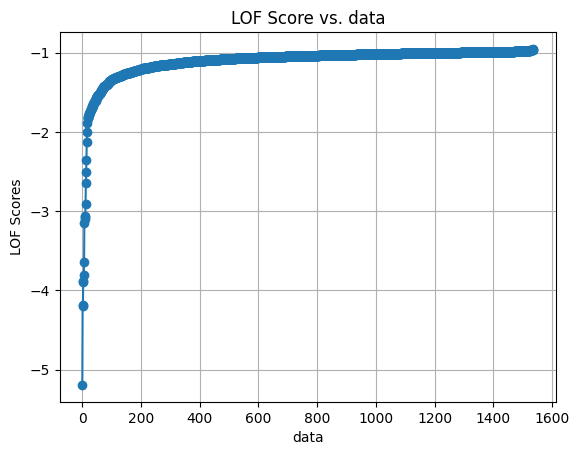

In [485]:
elbow_point,scores = handle_outliers.find_critical_lof(threshold=0.01)

In [486]:
elbow_point

-1.8243570603755963

In [487]:
scores 

,0
0,-1.022767
1,-0.978225
2,-1.015531
3,-1.024899
4,-1.144594
...,...
1532,-1.242264
1533,-0.992300
1534,-1.038762
1535,-1.005775


In [90]:
scores[scores[0]<elbow_point]

,0
174,-3.885309
190,-3.806387
345,-4.197266
541,-5.191968
574,-3.075552
608,-2.000295
664,-2.906437
673,-3.644965
786,-1.891917
853,-3.897642


In [490]:
out_ind = scores[scores[0]<elbow_point].index.tolist()

In [495]:
df_zero_std_dropped.iloc[out_ind]["Good/Bad"].value_counts()  # thi suggests that being identified as an outlier by LOF  does not mean that you are a fault

Good/Bad
0    16
1     2
Name: count, dtype: int64

****

#### -> DATA TRANSFORMATION: Handle Scaling

In [21]:
class HandleScaling:
    def __init__(self,dataframe:pd.DataFrame):
        self.dataframe = dataframe

    def standard_scaler(self):
        ss = StandardScaler()
        return pd.DataFrame(ss.fit_transform(self.dataframe),columns=self.dataframe.columns)
    
    def robust_scaler(self):
        rs = RobustScaler()
        return pd.DataFrame(rs.fit_transform(self.dataframe),columns=self.dataframe.columns)


    def min_max_scaler(self,feature_range=(0,1)):
        mms = MinMaxScaler(feature_range=feature_range)
        return pd.DataFrame(mms.fit_transform(self.dataframe),columns=self.dataframe.columns)



In [22]:
def handle_imbalance(X,y):
    smt = SMOTETomek(random_state=11,sampling_strategy="minority")
    return smt.fit_resample(X,y)


### <<< NOW SCALE ALL THE COLUMNS THEN CHECK DISTRIBUTION TYPES >>>

## MODEL SELECTION/TRAINING

In [23]:
def evaluate_clf(true,predicted):
    acc = accuracy_score(true,predicted)
    f1 = f1_score(true,predicted)
    precision = precision_score(true,predicted)
    recall = recall_score(true,predicted)
    roc_auc = roc_auc_score(true,predicted)
    
    return acc, f1, precision, recall , roc_auc 

In [24]:
def total_cost(true,pred):
    tn, fp, fn, tp = confusion_matrix(true,pred).ravel()
    cost = 10*fn + 1*fp 
    return cost 

In [25]:
def evaluate_models(X,y,models:dict)->pd.DataFrame:
    X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.25, random_state=11)
    
    models_list = []
    accuracy_list = []
    cost_list = []

    for model_name, model_obj in models.items():
        model_obj.fit(X_train,y_train)

        y_train_pred = model_obj.predict(X_train)
        y_test_pred = model_obj.predict(X_test)

        # model performance on training dataset
        train_acc, train_f1, train_precision, train_recall , train_roc_auc = evaluate_clf(y_train,y_train_pred) 
        train_cost = total_cost(y_train, y_train_pred)

        # model performance on testing dataset
        test_acc, test_f1, test_precision, test_recall , test_roc_auc = evaluate_clf(y_test,y_test_pred) 
        test_cost = total_cost(y_test, y_test_pred)

        print(model_name)
        models_list.append(model_name)  


        print('Model performance for Training set')
        print("- Accuracy: {:.4f}".format(train_acc))
        print('- F1 score: {:.4f}'.format(train_f1)) 
        print('- Precision: {:.4f}'.format(train_precision))
        print('- Recall: {:.4f}'.format(train_recall))
        print('- Roc Auc Score: {:.4f}'.format(train_roc_auc))
        print(f'- COST: {train_cost}.')

        print('----------------------------------')

        print('Model performance for Test set')
        print('- Accuracy: {:.4f}'.format(test_acc))
        print('- F1 score: {:.4f}'.format(test_f1))
        print('- Precision: {:.4f}'.format(test_precision))
        print('- Recall: {:.4f}'.format(test_recall))
        print('- Roc Auc Score: {:.4f}'.format(test_roc_auc))
        print(f'- COST: {test_cost}.')
        cost_list.append(test_cost)
        print('='*35)
        print('\n')
        
    report = pd.DataFrame(list(zip(models_list,cost_list)),columns=["Model Name","Cost"])
    return report 



#### Now, we initialize the models we want to investigate in a dictionary

In [26]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import IsolationForest

In [124]:
# after checking perfomances of various models, ensemble classifiers especially XGBClassifier outperforms and generalizes the best.
# Furthermore, we could train a neural network also, but the results from XGBClassifier was satisfactory.

models = {
    "XGBClassifier" : XGBClassifier(
        random_state=11,
        scale_pos_weight=30,
        reg_alpha=0.01),
 
    #"IsolationForest":IsolationForest(n_estimators=100,max_samples=500, 
    #            contamination=0.1,random_state=11, verbose=0)
    #"SVC": SVC(probability=True,class_weight={0: 1, 1: 50}),
    #"knn":KNeighborsClassifier()
}

### Some common data transformations before Model Training Step

### NOTES
- all meaningful input features are float64 dtype
- wafer id can be removed
- no duplicated rows
- raw data is highly unscaled
- lots of outliers, even when i set iqr_threshold to 5% and coefficient to 5, there were still lots of outliers
- as an alternative, i peformed multivariate outlier detection using LOF, the elbow method suggested the threshold score to be <-2
- there is no duplicated rows, but are a lot of (more than 100) duplicated columns, may be these are all zero columns.
- there are 112 columns of constant value "0" 
- best_fit_distribution types are found , re-assess after data transformation
- highly imbalanced dataset, handle imbalance with stratified kfold when splitting as train-test dataset
- correlation study is performed with filter condition of abs(corr)>95 or abs(cor)<100 and if the correlated column count > threshold=5  , some columns meeting these conditions are detected

In [28]:
df_merged = drop_zero_std(df_merged)

In [29]:
df_merged = drop_duplicated_cols(df_merged)

In [30]:
df_merged.shape 

(1537, 475)

****

****

missing value imputation = fillna with [constant(0, mean, median),knn imputer]

outlier detection = 

In [46]:
def create_train_test(dataframe):
    X= dataframe.drop("Good/Bad", axis="columns")
    y= dataframe["Good/Bad"]
    X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.20, random_state=11,stratify=y)
    
    """X_train = X_train.reset_index(drop=True).fillna(0)
    X_test = X_test.reset_index(drop=True).fillna(0)
    y_train = y_train.reset_index(drop=True)
    y_test = y_test.reset_index(drop=True)"""

    return X_train, X_test, y_train, y_test
    

In [455]:
model = models["XGBClassifier"]

In [32]:
thresholds = [i*0.0005 for i in range(1,1200)]

In [33]:
df_corr = pd.DataFrame()

In [34]:
df_corr["Sensor_id"] = df_merged.columns[:-1].tolist()


In [35]:
corr_score = [abs(round(df_merged[[col,"Good/Bad"]].corr().iloc[0,1],4)) for col in df_merged.columns[:-1]]

In [36]:
df_corr["corr"] = corr_score

In [37]:
df_corr.sort_values(by="corr",ascending=False)

,Sensor_id,corr
293,Sensor-349,0.1287
96,Sensor-104,0.1286
149,Sensor-159,0.1213
248,Sensor-294,0.1145
104,Sensor-112,0.1139
...,...,...
201,Sensor-220,0.0006
109,Sensor-117,0.0006
324,Sensor-392,0.0005
430,Sensor-547,0.0005


In [38]:
highly_corr_cols = df_corr.sort_values(by="corr",ascending=False)[:200]["Sensor_id"].to_list()

In [39]:
def eval_models(X_train,X_test,y_train,y_test, models:dict, threshold_list:list)->int:

    cost_list = [] 

    for model_name, model_obj in models.items():

        print(f"Results for {model_name} \n")

        model_obj.fit(X_train,y_train)

        y_pred_train_proba = model_obj.predict_proba(X_train)
        y_pred_test_proba = model_obj.predict_proba(X_test)

        for threshold in threshold_list:

            y_train_pred = (y_pred_train_proba[:,1]>threshold).astype(int)
            y_test_pred = (y_pred_test_proba[:,1]>threshold).astype(int)

            train_metrics = evaluate_clf(y_train,y_train_pred)
            test_metrics = evaluate_clf(y_test,y_test_pred)

            train_cost = total_cost(y_train,y_train_pred)
            test_cost = total_cost(y_test,y_test_pred)

            f1_score_train = round(train_metrics[1],4)
            f1_score_test  = round(test_metrics[1],4)
            roc_auc_train  = round(train_metrics[-1],4)
            roc_auc_test   = round(test_metrics[-1],4)

            cost_list.append(test_cost)
            
            print(f"RESULTS FOR THRESHOLD: {threshold}")
            print(f"TRAINING: F1-score: {f1_score_train}, ROC AUC: {roc_auc_train}, Cost: {train_cost}")
            print(f"TESTING : F1-score: {f1_score_test}, ROC AUC: {roc_auc_test}, Cost: {test_cost}")
    
            print("CONFUSION MATRICES:\n",confusion_matrix(y_train,y_train_pred), "\n",confusion_matrix(y_test,y_test_pred))
    
    return sorted(cost_list,reverse=False)[0]


In [604]:
X_train, X_test, y_train, y_test = create_train_test(df_merged)

In [605]:
X_train_res, y_train_res = handle_imbalance(X_train[highly_corr_cols],y_train)

In [606]:
eval_models(X_train_res, X_test[highly_corr_cols], y_train_res, y_test,models,thresholds)

Results for XGBClassifier 

RESULTS FOR THRESHOLD: 0.0005
TRAINING: F1-score: 0.7838, ROC AUC: 0.7241, Cost: 639
TESTING : F1-score: 0.165, ROC AUC: 0.6774, Cost: 181
CONFUSION MATRICES:
 [[ 519  639]
 [   0 1158]] 
 [[119 171]
 [  1  17]]
RESULTS FOR THRESHOLD: 0.001
TRAINING: F1-score: 0.8242, ROC AUC: 0.7867, Cost: 494
TESTING : F1-score: 0.1828, ROC AUC: 0.7119, Cost: 161
CONFUSION MATRICES:
 [[ 664  494]
 [   0 1158]] 
 [[139 151]
 [  1  17]]
RESULTS FOR THRESHOLD: 0.0015
TRAINING: F1-score: 0.8527, ROC AUC: 0.8273, Cost: 400
TESTING : F1-score: 0.1637, ROC AUC: 0.6492, Cost: 179
CONFUSION MATRICES:
 [[ 758  400]
 [   0 1158]] 
 [[151 139]
 [  4  14]]
RESULTS FOR THRESHOLD: 0.002
TRAINING: F1-score: 0.871, ROC AUC: 0.8519, Cost: 343
TESTING : F1-score: 0.1635, ROC AUC: 0.6404, Cost: 178
CONFUSION MATRICES:
 [[ 815  343]
 [   0 1158]] 
 [[162 128]
 [  5  13]]
RESULTS FOR THRESHOLD: 0.0025
TRAINING: F1-score: 0.8867, ROC AUC: 0.8722, Cost: 296
TESTING : F1-score: 0.1467, ROC AUC: 0.

141

In [147]:
from xgboost import plot_importance

In [144]:
importance_score = model.feature_importances_*100
features = X_train.columns.tolist()

In [177]:
sorted(list(zip(importance_score,features)),reverse=True)[:35]

[(7.676576, 'Sensor-130'),
 (5.9024577, 'Sensor-344'),
 (4.788493, 'Sensor-281'),
 (3.9142046, 'Sensor-34'),
 (3.6618855, 'Sensor-40'),
 (3.5445266, 'Sensor-355'),
 (3.014964, 'Sensor-8'),
 (2.7965815, 'Sensor-198'),
 (2.7844715, 'Sensor-273'),
 (2.742893, 'Sensor-485'),
 (2.6477659, 'Sensor-2'),
 (2.632059, 'Sensor-91'),
 (2.6019378, 'Sensor-71'),
 (2.5676699, 'Sensor-177'),
 (2.5322008, 'Sensor-556'),
 (2.5028465, 'Sensor-256'),
 (2.497344, 'Sensor-576'),
 (2.472734, 'Sensor-79'),
 (2.378416, 'Sensor-132'),
 (2.3090942, 'Sensor-15'),
 (2.2822146, 'Sensor-475'),
 (2.26977, 'Sensor-394'),
 (2.2687619, 'Sensor-33'),
 (2.1891534, 'Sensor-553'),
 (2.1651933, 'Sensor-312'),
 (2.156952, 'Sensor-77'),
 (2.0781665, 'Sensor-99'),
 (2.0620625, 'Sensor-116'),
 (2.0147438, 'Sensor-80'),
 (1.9768479, 'Sensor-138'),
 (1.9341903, 'Sensor-51'),
 (1.8532726, 'Sensor-456'),
 (1.8180629, 'Sensor-89'),
 (1.7982707, 'Sensor-151'),
 (1.7496085, 'Sensor-586')]

In [200]:
important_features = [feat for score,feat in sorted(list(zip(importance_score,features)),reverse=True)[:100] ]

*****

In [385]:
from sklearn.model_selection import StratifiedKFold

# Define the number of folds (K)
n_splits = 5

skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=11)
X_test = X_test[highly_corr_cols]
for test_index, val_index in skf.split(X_test,y_test):
    #print(test_index,val_index)
    X_test_cv, X_val = X_test.iloc[test_index], X_test.iloc[val_index]
    #print(X_train_cv)
    y_test_cv, y_val = y_test.iloc[test_index], y_test.iloc[val_index]

    # Apply SMOTE to X_train_cv and y_train_cv
    #X_train_res, y_train_res = handle_imbalance(X_train_cv, y_train_cv)

    #model.fit(X_train_res,y_train_res)
    
    print("##################################\n")
    for threshold in [i*0.001 for i in range(4,10)]:
        
        y_val_pred_proba = model.predict_proba(X_val)
        y_val_pred = (y_val_pred_proba[:,1]>threshold).astype(int)

        metrics = evaluate_clf(y_val,y_val_pred)
        cost = total_cost(y_val, y_val_pred)
        print(f"Threshold {threshold}: F1-score: {round(metrics[1],4)}, ROC AUC: {round(metrics[-1],4)}, Cost: {cost}")
        print(confusion_matrix(y_val,y_val_pred))
    print("##################################\n\n")

##################################

Threshold 0.004: F1-score: 0.1935, ROC AUC: 0.6681, Cost: 34
[[34 24]
 [ 1  3]]
Threshold 0.005: F1-score: 0.2, ROC AUC: 0.6767, Cost: 33
[[35 23]
 [ 1  3]]
Threshold 0.006: F1-score: 0.2069, ROC AUC: 0.6853, Cost: 32
[[36 22]
 [ 1  3]]
Threshold 0.007: F1-score: 0.2143, ROC AUC: 0.694, Cost: 31
[[37 21]
 [ 1  3]]
Threshold 0.008: F1-score: 0.2143, ROC AUC: 0.694, Cost: 31
[[37 21]
 [ 1  3]]
Threshold 0.009000000000000001: F1-score: 0.2222, ROC AUC: 0.7026, Cost: 30
[[38 20]
 [ 1  3]]
##################################


##################################

Threshold 0.004: F1-score: 0.24, ROC AUC: 0.7198, Cost: 28
[[40 18]
 [ 1  3]]
Threshold 0.005: F1-score: 0.25, ROC AUC: 0.7284, Cost: 27
[[41 17]
 [ 1  3]]
Threshold 0.006: F1-score: 0.25, ROC AUC: 0.7284, Cost: 27
[[41 17]
 [ 1  3]]
Threshold 0.007: F1-score: 0.2609, ROC AUC: 0.7371, Cost: 26
[[42 16]
 [ 1  3]]
Threshold 0.008: F1-score: 0.2727, ROC AUC: 0.7457, Cost: 25
[[43 15]
 [ 1  3]]
Thresho

In [440]:

n_splits = 5

skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

for test_index, val_index in skf.split(X_test, y_test):
    #print(train_index,val_index)
    X_test_cv, X_val = X_test.iloc[test_index], X_test.iloc[val_index]
    #print(X_train_cv)
    y_test_cv, y_val = y_test[test_index], y_test[val_index]

    

    for threshold in thresholds:
        
        y_val_pred_proba = model.predict_proba(X_val)
        y_val_pred = (y_val_pred_proba[:,1]>threshold).astype(int)

        metrics = evaluate_clf(y_val,y_val_pred)
        cost = total_cost(y_val, y_val_pred)
        print(f"Threshold {threshold}: F1-score: {round(metrics[1],4)}, ROC AUC: {round(metrics[-1],4)}, Cost: {cost*5}")
        print(confusion_matrix(y_val,y_val_pred)*5)
    print("##################################\n\n")

Threshold 0.1: F1-score: 0.0, ROC AUC: 0.4384, Cost: 245
[[320  45]
 [ 20   0]]
Threshold 0.2: F1-score: 0.0, ROC AUC: 0.4589, Cost: 230
[[335  30]
 [ 20   0]]
Threshold 0.3: F1-score: 0.0, ROC AUC: 0.4658, Cost: 225
[[340  25]
 [ 20   0]]
Threshold 0.4: F1-score: 0.0, ROC AUC: 0.4863, Cost: 210
[[355  10]
 [ 20   0]]
Threshold 0.5: F1-score: 0.0, ROC AUC: 0.4863, Cost: 210
[[355  10]
 [ 20   0]]
Threshold 0.6: F1-score: 0.0, ROC AUC: 0.4863, Cost: 210
[[355  10]
 [ 20   0]]
Threshold 0.7: F1-score: 0.0, ROC AUC: 0.4863, Cost: 210
[[355  10]
 [ 20   0]]
Threshold 0.8: F1-score: 0.0, ROC AUC: 0.4863, Cost: 210
[[355  10]
 [ 20   0]]
Threshold 0.9: F1-score: 0.0, ROC AUC: 0.5, Cost: 200
[[365   0]
 [ 20   0]]
##################################


Threshold 0.1: F1-score: 0.1053, ROC AUC: 0.5291, Cost: 220
[[295  70]
 [ 15   5]]
Threshold 0.2: F1-score: 0.0, ROC AUC: 0.4452, Cost: 240
[[325  40]
 [ 20   0]]
Threshold 0.3: F1-score: 0.0, ROC AUC: 0.4521, Cost: 235
[[330  35]
 [ 20   0]]
Thr

## EXPERIMENT #1 

- imputation: Simple Imputer with mean, median & constant values
- imbalance handling: SMOTETomek
- no outlier handling
- scaling : Standard Scaler
- no correlation handling

In [96]:
df_1 = restore_original_data()
df_1 = drop_zero_std(df_1)
df_1 = drop_duplicated_cols(df_1)

In [97]:
df_1 = df_1[highly_corr_cols]

In [98]:
X_train, X_test, y_train, y_test = create_train_test(df_1)

In [99]:
df_train = pd.concat([X_train,y_train],axis=1)
df_test  = pd.concat([X_test,y_test])

In [100]:
df_train.isna().sum().sum()

15967

In [101]:
"""first we need to split df_merged[highly_corr_cols] into df_train, df_test then 
    perform imputation, balancing and scaling on train dataset, train the model
    then apply scale_ params (mean,std etc.) to test dataset to evaluate model performance
    """

handle_missing = HandleMissingValues(df_train)

methods= ["mean","median","constant","knn"]

imputed_df_dict = {
    "mean_imputed_df":None,
    "median_imputed_df":None,
    "constant_imputed_df":None,
    "knn_imputed_df":None
}

for method in methods:

    imputed_df_dict[f"{method}_imputed_df"] = handle_missing.handle_imputation(method)



In [102]:
imputed_df_dict["mean_imputed_df"].isna().sum().sum()+ imputed_df_dict["median_imputed_df"].isna().sum().sum() + \
imputed_df_dict["constant_imputed_df"].isna().sum().sum() + imputed_df_dict["knn_imputed_df"].isna().sum().sum()


0

In [103]:
for name, df in imputed_df_dict.items():

    
    X_balanced, y_balanced = handle_imbalance(df.iloc[:,:-1],df.iloc[:,-1])
    imputed_df_dict[name] = (X_balanced,y_balanced) # store as tuple
        

In [71]:
imputed_df_dict["mean_imputed_df"][1].value_counts()  # which is y_train of mean imputed df_train

Good/Bad
0.0    1157
1.0    1157
Name: count, dtype: int64

In [82]:
mean_imp_X_train,mean_imp_y_train = imputed_df_dict["mean_imputed_df"]


In [83]:
s_scaler= StandardScaler()
mean_imp_X_train_scaled= s_scaler.fit_transform(mean_imp_X_train)

In [91]:
X_test_scaled = s_scaler.transform(X_test)

In [95]:
eval_models(mean_imp_X_train_scaled,X_test_scaled,mean_imp_y_train,y_test,models,thresholds)

Results for XGBClassifier 

RESULTS FOR THRESHOLD: 0.0005
TRAINING: F1-score: 0.7783, ROC AUC: 0.7152, Cost: 659
TESTING : F1-score: 0.1478, ROC AUC: 0.636, Cost: 205
CONFUSION MATRICES:
 [[ 498  659]
 [   0 1157]] 
 [[ 95 195]
 [  1  17]]
RESULTS FOR THRESHOLD: 0.001
TRAINING: F1-score: 0.8174, ROC AUC: 0.7766, Cost: 517
TESTING : F1-score: 0.1524, ROC AUC: 0.641, Cost: 196
CONFUSION MATRICES:
 [[ 640  517]
 [   0 1157]] 
 [[114 176]
 [  2  16]]
RESULTS FOR THRESHOLD: 0.0015
TRAINING: F1-score: 0.8384, ROC AUC: 0.8073, Cost: 446
TESTING : F1-score: 0.1505, ROC AUC: 0.6234, Cost: 194
CONFUSION MATRICES:
 [[ 711  446]
 [   0 1157]] 
 [[136 154]
 [  4  14]]
RESULTS FOR THRESHOLD: 0.002
TRAINING: F1-score: 0.857, ROC AUC: 0.8332, Cost: 386
TESTING : F1-score: 0.16, ROC AUC: 0.6423, Cost: 183
CONFUSION MATRICES:
 [[ 771  386]
 [   0 1157]] 
 [[147 143]
 [  4  14]]
RESULTS FOR THRESHOLD: 0.0025
TRAINING: F1-score: 0.8686, ROC AUC: 0.8487, Cost: 350
TESTING : F1-score: 0.1512, ROC AUC: 0.618

127

### Experiment#1 standard-scaler, mean imputation, balanced train dataset conclusions
- for scale_pos_weight = 20, reg_alpha = 0.1:
    - best threshold range : [0.28-0.35] : take 0.3 -> roc_auc = 0.655, f1-score = 0.2917, cost= 133

****

In [104]:
median_imp_X_train,median_imp_y_train = imputed_df_dict["median_imputed_df"]
s_scaler= StandardScaler()
median_imp_X_train_scaled= s_scaler.fit_transform(median_imp_X_train)
X_test_scaled = s_scaler.transform(X_test)

In [105]:
eval_models(median_imp_X_train_scaled,X_test_scaled,median_imp_y_train,y_test,models,thresholds)

Results for XGBClassifier 

RESULTS FOR THRESHOLD: 0.0005
TRAINING: F1-score: 0.7757, ROC AUC: 0.7109, Cost: 669
TESTING : F1-score: 0.1459, ROC AUC: 0.6308, Cost: 208
CONFUSION MATRICES:
 [[ 488  669]
 [   0 1157]] 
 [[ 92 198]
 [  1  17]]
RESULTS FOR THRESHOLD: 0.001
TRAINING: F1-score: 0.8128, ROC AUC: 0.7697, Cost: 533
TESTING : F1-score: 0.1659, ROC AUC: 0.6791, Cost: 180
CONFUSION MATRICES:
 [[ 624  533]
 [   0 1157]] 
 [[120 170]
 [  1  17]]
RESULTS FOR THRESHOLD: 0.0015
TRAINING: F1-score: 0.8354, ROC AUC: 0.8029, Cost: 456
TESTING : F1-score: 0.1675, ROC AUC: 0.6738, Cost: 177
CONFUSION MATRICES:
 [[ 701  456]
 [   0 1157]] 
 [[133 157]
 [  2  16]]
RESULTS FOR THRESHOLD: 0.002
TRAINING: F1-score: 0.8577, ROC AUC: 0.8341, Cost: 384
TESTING : F1-score: 0.1758, ROC AUC: 0.6893, Cost: 168
CONFUSION MATRICES:
 [[ 773  384]
 [   0 1157]] 
 [[142 148]
 [  2  16]]
RESULTS FOR THRESHOLD: 0.0025
TRAINING: F1-score: 0.8719, ROC AUC: 0.8531, Cost: 340
TESTING : F1-score: 0.1754, ROC AUC: 

127

In [110]:
r_scaler = RobustScaler()
median_imp_X_train_scaled= r_scaler.fit_transform(median_imp_X_train)
X_test_scaled = r_scaler.transform(X_test)
eval_models(median_imp_X_train_scaled,X_test_scaled,median_imp_y_train,y_test,models,thresholds)
# cost 127

Results for XGBClassifier 

RESULTS FOR THRESHOLD: 0.0005
TRAINING: F1-score: 0.7757, ROC AUC: 0.7109, Cost: 669
TESTING : F1-score: 0.1459, ROC AUC: 0.6308, Cost: 208
CONFUSION MATRICES:
 [[ 488  669]
 [   0 1157]] 
 [[ 92 198]
 [  1  17]]
RESULTS FOR THRESHOLD: 0.001
TRAINING: F1-score: 0.8128, ROC AUC: 0.7697, Cost: 533
TESTING : F1-score: 0.1659, ROC AUC: 0.6791, Cost: 180
CONFUSION MATRICES:
 [[ 624  533]
 [   0 1157]] 
 [[120 170]
 [  1  17]]
RESULTS FOR THRESHOLD: 0.0015
TRAINING: F1-score: 0.8354, ROC AUC: 0.8029, Cost: 456
TESTING : F1-score: 0.1675, ROC AUC: 0.6738, Cost: 177
CONFUSION MATRICES:
 [[ 701  456]
 [   0 1157]] 
 [[133 157]
 [  2  16]]
RESULTS FOR THRESHOLD: 0.002
TRAINING: F1-score: 0.8577, ROC AUC: 0.8341, Cost: 384
TESTING : F1-score: 0.1758, ROC AUC: 0.6893, Cost: 168
CONFUSION MATRICES:
 [[ 773  384]
 [   0 1157]] 
 [[142 148]
 [  2  16]]
RESULTS FOR THRESHOLD: 0.0025
TRAINING: F1-score: 0.8719, ROC AUC: 0.8531, Cost: 340
TESTING : F1-score: 0.1754, ROC AUC: 

127

### Experiment#2 standard-scaler, median imputation, balanced train dataset conclusions
- for scale_pos_weight = 20, reg_alpha = 0.1:
    - best threshold range : [0.35-0.3675] : take 0.36 -> F1-score: 0.3182, ROC AUC: 0.6617, cost= 129

- if robust scaler is applied: cost = 127

****

In [106]:
constant_imp_X_train,constant_imp_y_train = imputed_df_dict["constant_imputed_df"]
s_scaler= StandardScaler()
constant_imp_X_train_scaled= s_scaler.fit_transform(constant_imp_X_train)
X_test_scaled = s_scaler.transform(X_test)

In [107]:
eval_models(constant_imp_X_train_scaled,X_test_scaled,constant_imp_y_train,y_test,models,thresholds)

Results for XGBClassifier 

RESULTS FOR THRESHOLD: 0.0005
TRAINING: F1-score: 0.7777, ROC AUC: 0.7142, Cost: 662
TESTING : F1-score: 0.1284, ROC AUC: 0.5682, Cost: 226
CONFUSION MATRICES:
 [[ 496  662]
 [   0 1158]] 
 [[104 186]
 [  4  14]]
RESULTS FOR THRESHOLD: 0.001
TRAINING: F1-score: 0.8158, ROC AUC: 0.7742, Cost: 523
TESTING : F1-score: 0.1443, ROC AUC: 0.6096, Cost: 202
CONFUSION MATRICES:
 [[ 635  523]
 [   0 1158]] 
 [[128 162]
 [  4  14]]
RESULTS FOR THRESHOLD: 0.0015
TRAINING: F1-score: 0.84, ROC AUC: 0.8096, Cost: 441
TESTING : F1-score: 0.1522, ROC AUC: 0.6268, Cost: 192
CONFUSION MATRICES:
 [[ 717  441]
 [   0 1158]] 
 [[138 152]
 [  4  14]]
RESULTS FOR THRESHOLD: 0.002
TRAINING: F1-score: 0.8575, ROC AUC: 0.8338, Cost: 385
TESTING : F1-score: 0.1582, ROC AUC: 0.6389, Cost: 185
CONFUSION MATRICES:
 [[ 773  385]
 [   0 1158]] 
 [[145 145]
 [  4  14]]
RESULTS FOR THRESHOLD: 0.0025
TRAINING: F1-score: 0.8713, ROC AUC: 0.8523, Cost: 342
TESTING : F1-score: 0.1628, ROC AUC: 0.

124

In [125]:
r_scaler= RobustScaler()
constant_imp_X_train_scaled= r_scaler.fit_transform(constant_imp_X_train)
X_test_scaled = r_scaler.transform(X_test)
eval_models(constant_imp_X_train_scaled,X_test_scaled,constant_imp_y_train,y_test,models,thresholds)

Results for XGBClassifier 

RESULTS FOR THRESHOLD: 0.0005
TRAINING: F1-score: 0.7777, ROC AUC: 0.7142, Cost: 662
TESTING : F1-score: 0.1488, ROC AUC: 0.6324, Cost: 201
CONFUSION MATRICES:
 [[ 496  662]
 [   0 1158]] 
 [[109 181]
 [  2  16]]
RESULTS FOR THRESHOLD: 0.001
TRAINING: F1-score: 0.8169, ROC AUC: 0.7759, Cost: 519
TESTING : F1-score: 0.1684, ROC AUC: 0.6755, Cost: 176
CONFUSION MATRICES:
 [[ 639  519]
 [   0 1158]] 
 [[134 156]
 [  2  16]]
RESULTS FOR THRESHOLD: 0.0015
TRAINING: F1-score: 0.8419, ROC AUC: 0.8122, Cost: 435
TESTING : F1-score: 0.1724, ROC AUC: 0.6736, Cost: 171
CONFUSION MATRICES:
 [[ 723  435]
 [   0 1158]] 
 [[149 141]
 [  3  15]]
RESULTS FOR THRESHOLD: 0.002
TRAINING: F1-score: 0.8645, ROC AUC: 0.8433, Cost: 363
TESTING : F1-score: 0.1728, ROC AUC: 0.6648, Cost: 170
CONFUSION MATRICES:
 [[ 795  363]
 [   0 1158]] 
 [[160 130]
 [  4  14]]
RESULTS FOR THRESHOLD: 0.0025
TRAINING: F1-score: 0.8793, ROC AUC: 0.8627, Cost: 318
TESTING : F1-score: 0.1772, ROC AUC: 

121

### Experiment#3 standard-scaler, constant imputation, balanced train dataset conclusions
- for scale_pos_weight = 30, reg_alpha = 0.1:
    - best threshold range : [0.25-0.275] : take 0.26 -> F1-score: 0.3404, ROC AUC: 0.686, Cost: 121

- if robust scaler is applied : cost = 121

****

In [108]:
knn_imp_X_train,knn_imp_y_train = imputed_df_dict["knn_imputed_df"]
s_scaler= StandardScaler()
knn_imp_X_train_scaled= s_scaler.fit_transform(knn_imp_X_train)
X_test_scaled = s_scaler.transform(X_test)

In [109]:
eval_models(knn_imp_X_train_scaled,X_test_scaled,knn_imp_y_train,y_test,models,thresholds)

Results for XGBClassifier 

RESULTS FOR THRESHOLD: 0.0005
TRAINING: F1-score: 0.7703, ROC AUC: 0.7018, Cost: 690
TESTING : F1-score: 0.1789, ROC AUC: 0.705, Cost: 165
CONFUSION MATRICES:
 [[ 467  690]
 [   0 1157]] 
 [[135 155]
 [  1  17]]
RESULTS FOR THRESHOLD: 0.001
TRAINING: F1-score: 0.8085, ROC AUC: 0.7632, Cost: 548
TESTING : F1-score: 0.1875, ROC AUC: 0.6977, Cost: 157
CONFUSION MATRICES:
 [[ 609  548]
 [   0 1157]] 
 [[163 127]
 [  3  15]]
RESULTS FOR THRESHOLD: 0.0015
TRAINING: F1-score: 0.8324, ROC AUC: 0.7986, Cost: 466
TESTING : F1-score: 0.1745, ROC AUC: 0.6577, Cost: 168
CONFUSION MATRICES:
 [[ 691  466]
 [   0 1157]] 
 [[172 118]
 [  5  13]]
RESULTS FOR THRESHOLD: 0.002
TRAINING: F1-score: 0.852, ROC AUC: 0.8263, Cost: 402
TESTING : F1-score: 0.1571, ROC AUC: 0.6142, Cost: 181
CONFUSION MATRICES:
 [[ 755  402]
 [   0 1157]] 
 [[179 111]
 [  7  11]]
RESULTS FOR THRESHOLD: 0.0025
TRAINING: F1-score: 0.8647, ROC AUC: 0.8436, Cost: 362
TESTING : F1-score: 0.1504, ROC AUC: 0.

129

In [112]:

r_scaler= RobustScaler()
knn_imp_X_train_scaled= r_scaler.fit_transform(knn_imp_X_train)
X_test_scaled = r_scaler.transform(X_test)
eval_models(knn_imp_X_train_scaled,X_test_scaled,knn_imp_y_train,y_test,models,thresholds)

Results for XGBClassifier 

RESULTS FOR THRESHOLD: 0.0005
TRAINING: F1-score: 0.7703, ROC AUC: 0.7018, Cost: 690
TESTING : F1-score: 0.1789, ROC AUC: 0.705, Cost: 165
CONFUSION MATRICES:
 [[ 467  690]
 [   0 1157]] 
 [[135 155]
 [  1  17]]
RESULTS FOR THRESHOLD: 0.001
TRAINING: F1-score: 0.8085, ROC AUC: 0.7632, Cost: 548
TESTING : F1-score: 0.1875, ROC AUC: 0.6977, Cost: 157
CONFUSION MATRICES:
 [[ 609  548]
 [   0 1157]] 
 [[163 127]
 [  3  15]]
RESULTS FOR THRESHOLD: 0.0015
TRAINING: F1-score: 0.8324, ROC AUC: 0.7986, Cost: 466
TESTING : F1-score: 0.1745, ROC AUC: 0.6577, Cost: 168
CONFUSION MATRICES:
 [[ 691  466]
 [   0 1157]] 
 [[172 118]
 [  5  13]]
RESULTS FOR THRESHOLD: 0.002
TRAINING: F1-score: 0.852, ROC AUC: 0.8263, Cost: 402
TESTING : F1-score: 0.1571, ROC AUC: 0.6142, Cost: 181
CONFUSION MATRICES:
 [[ 755  402]
 [   0 1157]] 
 [[179 111]
 [  7  11]]
RESULTS FOR THRESHOLD: 0.0025
TRAINING: F1-score: 0.8647, ROC AUC: 0.8436, Cost: 362
TESTING : F1-score: 0.1504, ROC AUC: 0.

129

### Experiment#4 standard-scaler, knn imputation, balanced train dataset conclusions
- for scale_pos_weight = 20, reg_alpha = 0.1:
    - best threshold range : [0.093-0.1] : take 0.095 -> F1-score: 0.3182, ROC AUC: 0.6617, Cost: 129
- if robust scaler is applied: cost = 129

### So, we are better to apply transformation pipeline consisting of :
- [drop_zero_std -> drop_duplicated_cols -> constant(0) imputation -> SMOTOMEK balancing -> Robust Scaling ] 

- then train model XGBClassifier using best params: {scale_pos_weight:30,reg_alpha:0.1} with threshold from the range: [0.25-0.275]
  
  to get the best results: F1-score: 0.3404, ROC AUC: 0.686, Cost: 121 -> Which yields 33% less costs than the initial problem case.

In [157]:
import dill

In [160]:
best_model =  XGBClassifier(
        random_state=11,
        scale_pos_weight=30,
        reg_alpha=0.01),

In [161]:
best_model_path = "best_model.pkl"

In [ ]:
with open(best_model_path,"wb") as f:
    dill.dump(best_model,f)

In [ ]:
transformer_pipeline = Pipeline(
    steps=[
        ("constant_imputer",SimpleImputer(strategy="constant",fill_value=0)),
        ("scaler",RobustScaler())       
    ])

In [153]:
class TrainingPreprocessor(BaseEstimator,TransformerMixin):
    def __init__(self,use_y = True):
        self.use_y = use_y

    def fit(self,X,y=None):
        if self.use_y:
            self.y = y 

        return self 
    
    def transform(self,X,is_testing=False):
        X_transformed = drop_zero_std(X)
        X_transformed = drop_duplicated_cols(X_transformed)
        X_transformed = X_transformed[highly_corr_cols[:-1]]

        imputer = SimpleImputer(strategy="constant",fill_value=0)
        X_transformed = imputer.fit_transform(X_transformed)

        if not is_testing:
            X_transformed , self.y = handle_imbalance(X_transformed,self.y)
            
        r_scaler = RobustScaler()
        X_transformed = r_scaler.fit_transform(X_transformed)

        return X_transformed, self.y 


In [150]:
preprocessor_obj = TrainingPreprocessor()

In [151]:
preprocessor_obj.fit(X_train,y_train)

TrainingPreprocessor()

In [158]:
file_path = "preprocessor_obj.pkl"
with open(file_path,"wb") as f :
    dill.dump(preprocessor_obj,f)

In [152]:
X_transformed, y_res = preprocessor_obj.transform(X_train)

In [148]:
X_transformed.std() 

1.0000000000000002

In [140]:
y_res.shape 

(2316,)

In [141]:
y_res.value_counts()

Good/Bad
0    1158
1    1158
Name: count, dtype: int64

In [159]:
model 

NameError: name 'model' is not defined